# Appendix B (Code)

## Load Dataset in Graph Form:

Upload the files located in the Graph_Data folder to the notebook before running!

## Code:

###  Imports, Configuration, Loading the dataset:

In [1]:
import pandas as pd
import pyarrow

In [2]:
# constants:
DATASET = 'HI-Small_Trans' 
# Reasoning behind dataset choice: Higher illicit rate allows easier training,
# while smaller size requires less computating resources.

# Paths of data files:
# File organization Path constant:
PATH = './'
# Feather format to improve load times and allow for easier training:
FORMAT = '.feather'
# Resulting dataset paths:
nodes_path = PATH + DATASET + '_nodes' + FORMAT
bank_bounds_path = PATH + DATASET + '_bank_bounds' + FORMAT
edges_path = PATH + DATASET + '_edges' + FORMAT
ys_path = PATH + DATASET + '_ys' + FORMAT
subgraphs_path = PATH + DATASET + '_subgraphs' + FORMAT

In [3]:
import graphviz
import dask.dataframe as dd
# Load Data:
# nodes_df contains nodes indexed in order by both bank and account:
nodes_df = dd.from_pandas(pd.read_feather(nodes_path),npartitions=32).compute()
# banks_df contains the associated lower bound and upper bound on the index of a node when provided with a bank:
banks_df = dd.from_pandas(pd.read_feather(bank_bounds_path).set_index('id'), npartitions=32).compute()
# edges_df contains the edge information for any transaction, with index pointers to its start and end nodes
edges_df = dd.from_pandas(pd.read_feather(edges_path), npartitions=32).compute()
# ys_df contains the desired information to predict, whether or not a transaction is Money Laundering:
ys_df = dd.from_pandas(pd.read_feather(ys_path), npartitions=32).compute()
# subgraphs_df contains the subgraph information:
subgraphs_df = dd.from_pandas(pd.read_feather(subgraphs_path), npartitions=32).compute()

## Efficient search capability for the index of a node:

In [4]:
def get_node_index(bank, acc):
    # Get inclusive bounds on index:
    [lb, ub] = banks_df.loc[bank][['lb', 'ub']]
    # While lower bound is less than upper bound, the node hasn't been found:
    while lb < ub:
        # Current index is the average of the lower and upper bound, rounded down:
        i = round((lb+ub)/2)
        # if current node acc is less than the desired node acc:
        if nodes_df.iloc[i]['Account'] < acc:
            # Then any nodes between lb and i inclusive's acc are less than acc, so:
            lb = i + 1
        # else if current node matches desired node, return i as node has been found:
        elif nodes_df.iloc[i]['Account'] == acc:
            return i
        # otherwise current node acc is greater than desired node acc:
        else:
            ub = i - 1
    # Make sure the current node matches the desired node:
    i = int((lb+ub)/2 - (lb+ub)%2)
    if int(nodes_df.iloc[i]['Bank']) == int(bank) and int(nodes_df.iloc[i]['Account'] == acc):
        return i
    # Throw an error otherwise:
    else:
        print(lb, ub)
        raise Exception('NodeNotFound')

### Tests for the above function:

In [5]:
 import numpy as np
 def run_tests(num_tests=10000):
     for i in np.random.randint(low=0,high=len(nodes_df),size=num_tests):
         node = nodes_df.iloc[i]
         assert (get_node_index(int(node['Bank']), str(node['Account'])) == i)
     print('passed', num_tests,'random tests')
 run_tests()

passed 10000 random tests


## Generate a visualization of the initial examples provided:

In [6]:
 import graphviz

 # Load file containing laundering attempts done under certain known patterns:
 laundering_attempts = pd.Series([i for i in open('./HI-Small_Patterns.txt')])
 # Remove unnecessary newline symbols:
 laundering_attempts = laundering_attempts.map(lambda s: s.replace('\n', ''))
 # Remove empty lines:
 laundering_attempts = laundering_attempts[laundering_attempts.map(lambda s: s != '')].reset_index(drop=True)
 # Format of lines that denote the start of a laundering attempt:
 beginining_format='BEGIN LAUNDERING ATTEMPT'
 # Format of lines that denote the end of a laundering attempt:
 ending_format='END LAUNDERING ATTEMPT'

 # Accumulators:
 beginings = []
 endings = []
 # Get indices of lines denoting starts and ends of laundering attempts
 for i, v in laundering_attempts.items():
   if beginining_format in v:
     beginings += [i]
   elif ending_format in v:
     endings += [i]
 # Show that length is the same:
 assert len(beginings) == len(endings), 'INCORRECT FORMAT'

 # Organize the lines by which laundering attempts they belong to
 temp = []
 for i in range(len(beginings)):
   start = beginings[i]
   end = endings[i]
   temp += [laundering_attempts.iloc[start:end+1]]
 laundering_attempts = temp

 # Generate a Digraph render of the graph that consists of the transactions
 # within the file, and right to pdf:
 dot = graphviz.Digraph()
 for laundering_attempt in laundering_attempts:
   transactions = laundering_attempt.iloc[1:-1]
   for transaction in transactions:
     values = transaction.split(',')
     start = str(get_node_index(int(values[1]), values[2]))
     end = str(get_node_index(int(values[3]), values[4]))
     dot.node(start)
     dot.node(end)
     dot.edge(start, end)
 dot.render('illicit_transaction_example_graph',format='pdf')


(process:1552): GLib-GIO-WARNING **: 13:05:14.129: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:1552): GLib-GIO-WARNING **: 13:05:14.521: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2303.17.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs


'illicit_transaction_example_graph.pdf'

## Split into subgraphs, add relevant data:

In [7]:
 # finding transaction partners of each node:
 print('finding transaction partners. This will likely take a couple minutes.')
 transaction_partners = []
 for i in range(len(nodes_df)):
     transaction_partners += [set([])]

 # Add transaction partners according to the edge
 def process_edge(edge, transaction_partners):
     s, e = edge['Start Node'], edge['End Node']
     transaction_partners[s].add(e)
     transaction_partners[e].add(s)

 # Make a call for each edge to be processed:
 dd.from_pandas(edges_df, npartitions=32).apply(
     lambda e: process_edge(e, transaction_partners),
     meta=(None, 'object'),
     axis=1
 ).compute()
 nodes_df['transaction partners'] = transaction_partners

 print(
     'processing nodes_df will require',
     len(nodes_df),
     'iterations. This will likely take a couple minutes.'
 )

 nodes_df['addable'] = True

 def split_graph():
     # subgraphs is an accumulator array for sets of nodes that make
     # up disconnected subgraphs within the dataset:
     subgraphs = []
     # current index counter:
     i = 0
     # current subgraph initial value:
     subgraph = []
     # horizon for the current subgraph:
     horizon = list()
     # settled nodes for the current subgraph:
     settled = []
     # While there are nodes that are not yet accounted for:
     while True:
         # if no nodes are in the horizon:
         if len(horizon) == 0:
             # if there are nodes in the subgraph:
             if len(subgraph) > 0:
                 # add the current subgraph to the list of subgraphs:
                 subgraphs += [subgraph.copy()]
             # Make a new list of subgraphs:
             subgraph = []
             # increment check index until the current node is addable to the horizon:
             while not nodes_df.loc[i,'addable']:
                 i += 1
                 # if i has exited the index of nodes_df, then all nodes are not addable,
                 # so finish:
                 if i == len(nodes_df):
                     return subgraphs
             # add the current node to the list of horizon nodes to process:
             horizon.append(i)
             # mark the current node as no longer being addable:
             nodes_df.loc[i, 'addable'] = False
         # get the current node:
         curr = horizon.pop()
         # add the current node to the subgraph:
         subgraph += [curr]
         # add all addable transaction partners of the node to the list of horizon nodes to process
         # and mark them as no longer being addable:
         for partner in nodes_df.loc[curr, 'transaction partners']:
             if nodes_df.loc[partner, 'addable']:
                 horizon.append(partner)
                 nodes_df.loc[partner,'addable'] = False

 subgraphs = split_graph()

 print('finished!')
 print('total nodes:', len(nodes_df))
 print('total subgraphs:', len(subgraphs))
 print(
     'total nodes in subgraphs (should match total nodes):',
     sum([len(subgraph) for subgraph in subgraphs])
 )

 subgraphs = pd.DataFrame({'nodes' : subgraphs})

 print('sorting subgraphs')
 # mapping subgraphs to series:
 subgraphs['nodes'] = subgraphs['nodes'].map(
     lambda ls: pd.Series(ls).sort_values().reset_index(drop=True)
 )

 print('Making changes to nodes')
 subgraph_ids = subgraphs['nodes'].explode()
 temp = pd.Series(subgraph_ids.index.tolist(), index = subgraph_ids.values.tolist())
 subgraph_ids = pd.Series(nodes_df.index.tolist())
 nodes_df['subgraph'] = subgraph_ids.map(lambda x: temp[x])
 # remove redundant column:
 nodes_df = nodes_df.drop(columns=['addable'])

 print('Making changes to edges')
 # map subgraph back to edges from nodes:
 edges_df['subgraph'] = edges_df['Start Node'].map(lambda n: nodes_df.loc[n,'subgraph'])

 print('Updating subgraph data')
 # Re-map subgraphs['nodes'] column to lists:
 subgraphs['nodes'] = subgraphs['nodes'].map(lambda ser: ser.values.tolist())
 # Get edge indices and number of edges and nodes for each subgraph:
 grouped_temp = edges_df.reset_index().groupby('subgraph')
 edge_count = grouped_temp['index'].count()
 subgraphs['num_edges'] = grouped_temp['index'].count()
 subgraphs['edges'] = grouped_temp['index'].apply(lambda g: g.values.tolist())
 subgraphs['num_nodes'] = subgraphs['nodes'].map(lambda x:len(x))

 # write changes to file:
 print('writing changes')
 subgraphs.to_feather(subgraphs_path)
 nodes_df.to_feather(nodes_path)
 edges_df.to_feather(edges_path)
 print('done')

finding transaction partners. This will likely take a couple minutes.
processing nodes_df will require 515088 iterations. This will likely take a couple minutes.
finished!
total nodes: 515088
total subgraphs: 114139
total nodes in subgraphs (should match total nodes): 515088
sorting subgraphs
Making changes to nodes
Making changes to edges
Updating subgraph data
writing changes
done


## Get change in accounts for nodes:

In [8]:
 import numpy as np
 currencies = list(
     set(
         edges_df['Receiving Currency'].tolist() +
         edges_df['Payment Currency'].tolist()
     )
 )
 num_currencies = len(list(set(currencies)))
 num_nodes = len(nodes_df)
 temp = np.zeros(shape=(num_nodes, num_currencies))
 c = {}
 c_rev = {}
 for i in range(len(currencies)):
   c[currencies[i]] = i
   c_rev[i] = currencies[i]
 def handle_edge(e):
   temp[e['Start Node'], c[e['Payment Currency']]] += e['Amount Paid']
   temp[e['End Node'], c[e['Receiving Currency']]] -= e['Amount Received']
 dd.from_pandas(edges_df, npartitions=32).apply(
     handle_edge, axis=1, meta=(None,'object')
 ).compute()
 deltas = pd.DataFrame(temp).rename(columns=c_rev)
 for col in deltas.columns:
   nodes_df['Delta ' + col] = deltas[col]
 nodes_df.to_feather(nodes_path)

In [9]:
edges_df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire',
       'Bitcoin'], dtype=object)

## Making final transformations to obtain a singular final dataframe:

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
# Convert Timestamp entries todatetime representation:
edges_df['Timestamp'] = pd.to_datetime(edges_df['Timestamp'])
# Get all unique transaction times in order:
temp = pd.Series(edges_df['Timestamp'].unique()).sort_values().reset_index(drop=True)
# Get the first time in the dataset:
min_time = min(temp)
# define a temporary series that can be used to map times to numerical values:
temp = pd.Series(
    temp.map(
        lambda t: (t - min_time)/np.timedelta64(1,'s')
    ).values.tolist(), 
    index = temp.map(lambda t: str(t)).values.tolist()
)
# convert Timestamp entries to numerical values:
edges_df['Timestamp'] = edges_df['Timestamp'].map(lambda t: temp[str(t)])
# Make final_df, a dataframe for containing all info in the end:
final_df = edges_df.copy()
# Remove this column from being added as we dont want to add it again:
temp = nodes_df.drop(columns=['subgraph'])
# Add columns containing information about the Start Node to the matrix:
final_df = final_df.join(
    temp,
    on='Start Node',
    how='left'
)
# Add columns containing information about the End Node to the matrix:
final_df = final_df.join(
    temp,
    on='End Node',
    how='left',
    lsuffix=' End',
    rsuffix=' Start'
)

# remove unwanted columns from final_df:
drop_columns = [
    'Payment Currency',
    'Receiving Currency',
    'Account End',
    'Account Start',
    'transaction partners End',
    'transaction partners Start'
]
# transform payment format into boolean features:
for form in final_df['Payment Format'].unique():
    final_df[form] = final_df['Payment Format'].map(lambda s: s == form)
final_df = final_df.drop(columns = ['Payment Format'])
final_df = final_df.drop(columns=drop_columns)

Y_col = 'Is Laundering'
# Add y column to final_df:
final_df[Y_col] = ys_df[Y_col]

## Tests for Decision Tree Classifier Fitting

Due to the highly unbalanced nature of the dataset, if the scoring while training the model was not adjusted to account for the low likelihood of a transaction being a money laundering attempt, then the model would not ever predict that a transaction was money laundering. As such, we train using the balanced accuracy score as our training metric in order to obtain some actual predictions.

The cell below fits 100 different decision tree classifiers to samples from the dataset and averages the resulting balanced accuracy score in order to obtain an idea of what sort of starting score we are looking at for our model.

In [11]:
from sklearn.tree import DecisionTreeClassifier
# specify number of times to run:
num_tests=100
# make accumulators:
balanced_scores = []
models = []
# specify size of sample to draw each time:
sample_size=1000000
for i in range(num_tests):
    # take a subset of transactions and split them into a train and test set:
    train, test = train_test_split(final_df.sample(sample_size), test_size=0.3)
    # separate columns and matrixes for fitting decision tree:
    X_cols = list(final_df.columns[:-1])
    X_train, X_test = train[X_cols], test[X_cols]
    Y_train, Y_test = train[Y_col], test[Y_col]
    # fit the decision tree:
    model = DecisionTreeClassifier(class_weight='balanced').fit(X_train, Y_train)
    # append the model and the balanced accuracy score:
    models += [model]
    balanced_scores += [balanced_accuracy_score(model.predict(X_test), Y_test)]
results = pd.Series(balanced_scores)
print('average balanced accuracy score:', results.mean())

average balanced accuracy score: 0.6036636688889316


## Making Improvements:

The cell below first transforms X with PCA, before fitting the decision tree.

C:\Users\chris\anaconda3\envs\ORIE4741\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\chris\anaconda3\envs\ORIE4741\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


fitting tree
final balanced accuracy score (through 5-fold cross validation): 0.5984658573914015


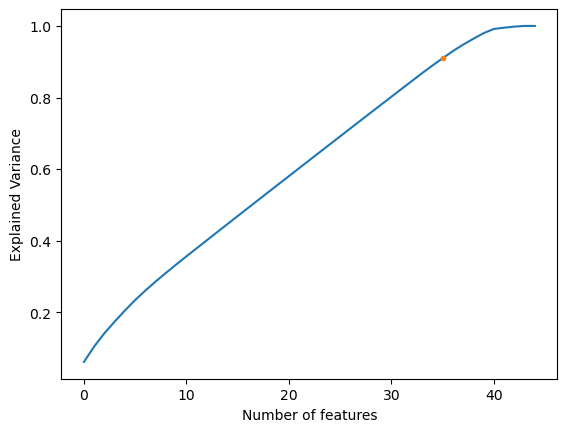

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt

# separate columns and matrixes for fitting decision tree:
X_cols = list(final_df.columns[:-1])
X  = final_df[X_cols]
Y = final_df[Y_col]

# apply PCA to x
    # scale X before PCA
scaler = StandardScaler()
scaler.fit(X)
scaled = scaler.transform(X)
    # decompose x according to PCA:
pca = PCA()
pca.fit(scaled)
decomposed = pca.transform(X)
    # plot results and select cutoff:
threshold = 0.9
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_var)
selected = min([j for j in range(len(explained_var)) if explained_var[j] > threshold])
plt.plot([selected], [explained_var[selected]], '.', label='selected cutoff')
plt.xlabel('Number of features')
plt.ylabel('Explained Variance')
    # redo PCA but only with desired number of components:
pca = PCA(n_components=selected)
pca.fit(scaled)
decomposed = pca.transform(X)
# fit the decision tree:
print('fitting tree')

tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(decomposed, Y)
# cross validate
print('final balanced accuracy score (through 5-fold cross validation):',cross_val_score(tree, X, Y,
            scoring="balanced_accuracy", 
            cv=5).mean())
